# **_Demand Forecasting Methods_**

<br>

### __*Import Libraries*__

In [319]:
# Data libraries
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Model libraries
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split

# Device config
device = torch.device('cuda')

<br>

### __*Load Data*__

In [320]:
# eurosd = pd.ExcelFile('data/eurosd_10y.xlsx') 10.1.2013 - 30.11.2022
raw_weather = pd.read_csv('data/seattle-weather.csv')

In [321]:
raw_weather[0::300]

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
300,2012-10-27,23.1,14.4,9.4,5.1,rain
600,2013-08-23,0.0,25.0,16.1,4.1,sun
900,2014-06-19,0.8,25.6,11.7,3.7,rain
1200,2015-04-15,0.0,13.9,3.3,2.4,sun


<br>

### __*Translate weather to numbers*__

In [322]:
def translator(labels):
    outp = dict()
    for label in labels:
        outp[label] = len(outp)
    return outp

In [323]:
weather_types = set(raw_weather['weather'])
translate = translator(weather_types)

In [324]:
translate

{'snow': 0, 'fog': 1, 'drizzle': 2, 'rain': 3, 'sun': 4}

In [325]:
for name, index in translate.items():
    raw_weather = raw_weather.replace(name, index)

In [326]:
raw_weather = raw_weather.drop(columns='date')
raw_weather[0::300]

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,2
300,23.1,14.4,9.4,5.1,3
600,0.0,25.0,16.1,4.1,4
900,0.8,25.6,11.7,3.7,3
1200,0.0,13.9,3.3,2.4,4


<br>

### __*Train & Test Data Split*__

In [327]:
X = raw_weather.to_numpy(dtype=float)
y = raw_weather[raw_weather.columns[1]].to_numpy(dtype=float)

# Based on last day data, what is going be the demand the next day
X_train, X_test, y_train, y_test = train_test_split(X[:-1], y[1:], test_size=0.1, shuffle=False)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

In [328]:
show = True
if show:
    for i in range(10):
        print(X_train[i][3], y_train[i], raw_weather['wind'][i], raw_weather['temp_max'][i])

tensor(4.7000) tensor(10.6000) 4.7 12.8
tensor(4.5000) tensor(11.7000) 4.5 10.6
tensor(2.3000) tensor(12.2000) 2.3 11.7
tensor(4.7000) tensor(8.9000) 4.7 12.2
tensor(6.1000) tensor(4.4000) 6.1 8.9
tensor(2.2000) tensor(7.2000) 2.2 4.4
tensor(2.3000) tensor(10.) 2.3 7.2
tensor(2.) tensor(9.4000) 2.0 10.0
tensor(3.4000) tensor(6.1000) 3.4 9.4
tensor(3.4000) tensor(6.1000) 3.4 6.1


<br>

### __*Define Linear Model*__

In [329]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        # self.fc2 = nn.Linear(512, 256)
        # self.fc3 = nn.Linear(256, 128)
        # self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, output_size)

    def forward(self, xx):
        xx = torch.relu(self.fc1(xx))
        # xx = torch.relu(self.fc2(xx))
        # xx = torch.relu(self.fc3(xx))
        # xx = torch.relu(self.fc4(xx))
        xx = torch.relu(self.fc5(xx))
        return self.fc6(xx)

<br>

### __*aaa*__

In [330]:
reg_model = LinearRegression(len(X_train[0]), 1)

train_loss_lst = list()
test_loss_lst = list()

<br>

### __*aaa*__

In [331]:
num_epochs = 50
len_train = len(X_train)
batch = 64

criterion = nn.SmoothL1Loss()                                # L1Loss
optimizer = optim.AdamW(reg_model.parameters(), lr=4e-4)     # AdamW 0.0001

for epoch in range(num_epochs):
    total_loss = 0
    tmp_outputs = list()
    for delta in range(int(len_train/batch) + 1):
        if delta == int(len_train/batch):
            inputs = X_train[batch*delta:]
            targets = y_train[batch*delta:]
        else:
            inputs = X_train[batch*delta:batch*(delta+1)]
            targets = y_train[batch*delta:batch*(delta+1)]

        # Forward pass
        outputs = reg_model(inputs)
        tmp_outputs.append(outputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    predictions = reg_model(X_test)
    acc = criterion(predictions, y_test)

    train_loss_lst.append(total_loss/len_train)
    test_loss_lst.append(acc.item())


    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}:\n'
              f'  Train Loss: {(total_loss/len(X_train)):.10f}\n'
              f'  Test  Loss: {acc.item()/len(X_test):.10f}')

        total_loss = 0

C:\Users\rposa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:928: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
C:\Users\rposa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:928: UserWarning: Using a target size (torch.Size([34])) that is different to the input size (torch.Size([34, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
C:\Users\rposa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:928: UserWarning: Using a target size (torch.Size([146])) that is different to the input size (torch.Size([146, 1])). This will likely lead to incorrect results due to broadcasting. Please ens

Epoch 1/50:
  Train Loss: 0.2436880173
  Test  Loss: 0.0904972325
Epoch 2/50:
  Train Loss: 0.2060723399
  Test  Loss: 0.0730370822
Epoch 3/50:
  Train Loss: 0.1582605567
  Test  Loss: 0.0560638807
Epoch 4/50:
  Train Loss: 0.1023259568
  Test  Loss: 0.0480099182
Epoch 5/50:
  Train Loss: 0.0662581189
  Test  Loss: 0.0498085251
Epoch 6/50:
  Train Loss: 0.0605983914
  Test  Loss: 0.0506970393
Epoch 7/50:
  Train Loss: 0.0599130720
  Test  Loss: 0.0496847728
Epoch 8/50:
  Train Loss: 0.0590550731
  Test  Loss: 0.0493876379
Epoch 9/50:
  Train Loss: 0.0584996242
  Test  Loss: 0.0490891999
Epoch 10/50:
  Train Loss: 0.0580274866
  Test  Loss: 0.0489200174
Epoch 11/50:
  Train Loss: 0.0576536144
  Test  Loss: 0.0487754770
Epoch 12/50:
  Train Loss: 0.0573403912
  Test  Loss: 0.0486116703
Epoch 13/50:
  Train Loss: 0.0570703436
  Test  Loss: 0.0484126692
Epoch 14/50:
  Train Loss: 0.0568048499
  Test  Loss: 0.0482033116
Epoch 15/50:
  Train Loss: 0.0566056078
  Test  Loss: 0.0479759419
Epoc

<br>

### __*aaa*__

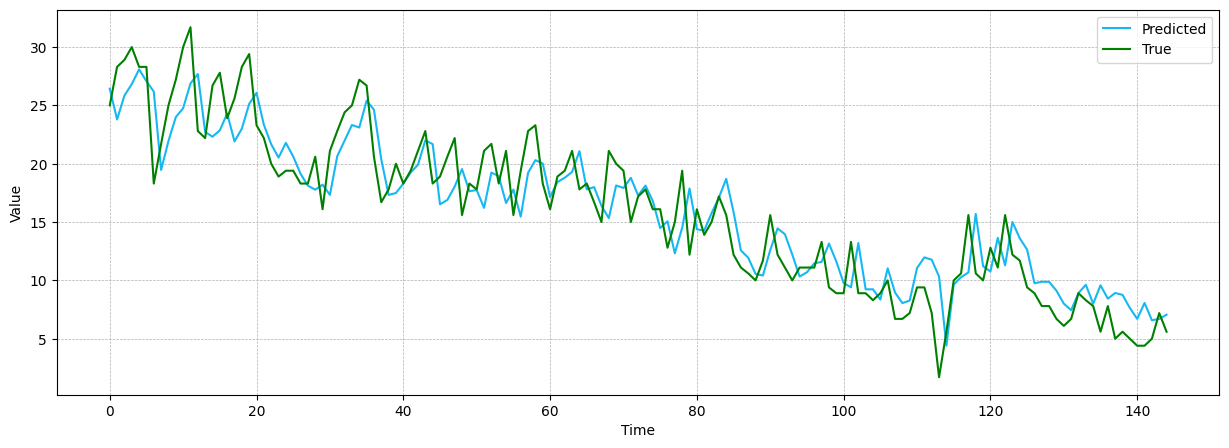

In [332]:
# Graphical representation of the model accuracy
start = 0
end = -1

predictions = reg_model(X_test)

_, axs_loss = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
test_loss_lst_plot, = axs_loss.plot(predictions.detach().numpy()[start:end], label='Predicted', color='#16b8f3')
train_loss_lst_plot, = axs_loss.plot(y_test[start:end], label='True', color='green')
axs_loss.legend(handles=[test_loss_lst_plot, train_loss_lst_plot])
axs_loss.grid(linestyle='--', linewidth=0.5)
axs_loss.set_xlabel('Time')
axs_loss.set_ylabel('Value')
pass

<br>

### __*aaa*__

In [333]:
for idx in range(len(predictions)):
    print(f'{idx:<3} Real: {(a:=y_test[idx]):>6.3f} | '
          f'Pred: {(b:=predictions.detach().numpy()[idx][0]):>6.3f} | '
          f'Diff: {abs(a - b):>6.3f}')

0   Real: 25.000 | Pred: 26.437 | Diff:  1.437
1   Real: 28.300 | Pred: 23.789 | Diff:  4.511
2   Real: 28.900 | Pred: 25.840 | Diff:  3.060
3   Real: 30.000 | Pred: 26.822 | Diff:  3.178
4   Real: 28.300 | Pred: 28.090 | Diff:  0.210
5   Real: 28.300 | Pred: 27.072 | Diff:  1.228
6   Real: 18.300 | Pred: 26.183 | Diff:  7.883
7   Real: 21.700 | Pred: 19.464 | Diff:  2.236
8   Real: 25.000 | Pred: 21.950 | Diff:  3.050
9   Real: 27.200 | Pred: 23.993 | Diff:  3.207
10  Real: 30.000 | Pred: 24.761 | Diff:  5.239
11  Real: 31.700 | Pred: 26.881 | Diff:  4.819
12  Real: 22.800 | Pred: 27.686 | Diff:  4.886
13  Real: 22.200 | Pred: 22.722 | Diff:  0.522
14  Real: 26.700 | Pred: 22.316 | Diff:  4.384
15  Real: 27.800 | Pred: 22.861 | Diff:  4.939
16  Real: 23.900 | Pred: 24.300 | Diff:  0.400
17  Real: 25.600 | Pred: 21.913 | Diff:  3.687
18  Real: 28.300 | Pred: 23.004 | Diff:  5.296
19  Real: 29.400 | Pred: 25.130 | Diff:  4.270
20  Real: 23.300 | Pred: 26.069 | Diff:  2.769
21  Real: 22.